<a href="https://colab.research.google.com/github/daripp/3d_data_extractor_and_stack_viewer/blob/main/3d_data_stacker%2C_extractor%2C_and_viewer.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
from google.colab import drive
drive.mount('/content/drive')
!ls "/content/drive/My Drive"


In [2]:
import glob
import numpy as np
import matplotlib.pyplot as plt
import skimage as sk
import tifffile as tifffile
import os as os
import numpy as np
from skimage import filters, transform, io

from skimage import filters, io, img_as_ubyte
from skimage.data import camera
import numpy as np
import matplotlib.pyplot as plt
import skimage as sk

from skimage import filters, io
from skimage.data import camera
from skimage import data, io,img_as_float64, img_as_float32, exposure
from skimage.exposure import histogram
from scipy import ndimage as ndi
import skimage as sk
from skimage.external import tifffile
from matplotlib import cm
from matplotlib import pyplot as plt
from skimage import img_as_float64, img_as_int
from mpl_toolkits.mplot3d.art3d import Poly3DCollection, Line3DCollection

import numpy as np

from scipy import ndimage as ndi

from skimage import (exposure, feature, filters, io, measure,
                      morphology, restoration, segmentation, transform,
                      util)
#name your new tiff stack here 
with tifffile.TiffWriter('drive/My Drive/filepath/stackname.tiff', bigtiff=True) as stack:
#put the file path to the folder of images you want to stack here
    dir_name = 'drive/My Drive/filepath/'
    filenames = os.listdir(dir_name)
    #remove extranious file info from the images here by splitting before and after the image #; this will make sure the images are ordered properly in the stack
    sort_idx = np.argsort([int(filename.split('ed')[1].split('.png')[0]) for filename in filenames])
    for i in sort_idx:
        filename = dir_name + filenames[i]
        
#         image=np.array(filename, dtype='ubyte')
#         image=np.array(filename)
        stack.save(io.imread(filename))


# %matplotlib inline

#***************************load tiff stack here
data = io.imread('drive/My Drive/filepath/stackname.tiff')
#data=np.array(data, dtype=int)
#data=img_as_int(data)

print("shape: {}".format(data.shape))
print("dtype: {}".format(data.dtype))
print("range: ({}, {})".format(data.min(), data.max()))
#io.imsave('data.tiff', data)
#io.imshow('data.tiff', cmap='binary')
print(data.shape[1])
print()

#i'm leaving this in because we might be able to use it to alter the spacing of your images.
#The microscope reports the following spacing
original_spacing = np.array([1.4, 1.4, 1.4])

# We downsampled each slice 4x to make the data smaller
rescaled_spacing = original_spacing * [1, 4, 4]

# Normalize the spacing so that pixels are a distance of 1 apart
spacing = rescaled_spacing / rescaled_spacing

print("microscope spacing: {}\n".format(original_spacing))
print("after rescaling images: {}\n".format(rescaled_spacing))
print("normalized spacing: {}\n".format(spacing))


def show_plane(ax, plane, cmap="gray", title=None):
    ax.imshow(plane, cmap=cmap)
    ax.set_xticks([])
    ax.set_yticks([])
    
    if title:
        ax.set_title(title)
def slice_in_3D(ax, i):
    # From:
    # https://stackoverflow.com/questions/44881885/python-draw-3d-cube

    import numpy as np
    from mpl_toolkits.mplot3d.art3d import Poly3DCollection, Line3DCollection

    Z = np.array([[0, 0, 0],
                  [1, 0, 0],
                  [1, 1, 0],
                  [0, 1, 0],
                  [0, 0, 1],
                  [1, 0, 1],
                  [1, 1, 1],
                  [0, 1, 1]])

    Z = Z * data.shape

    r = [-1,1]

    X, Y = np.meshgrid(r, r)
    # plot vertices
    ax.scatter3D(Z[:,0], Z[:,1], Z[:,2])

    # list of sides' polygons of figure
    verts = [[Z[0], Z[1], Z[2], Z[3]],
             [Z[4], Z[5], Z[6], Z[7]], 
             [Z[0], Z[1], Z[5], Z[4]], 
             [Z[2], Z[3], Z[7], Z[6]], 
             [Z[1], Z[2], Z[6], Z[5]],
             [Z[4], Z[7], Z[3], Z[0]], 
             [Z[2], Z[3], Z[7], Z[6]]]

    # plot sides
    ax.add_collection3d(
        Poly3DCollection(verts, facecolors=(0, 1, 1, 0.25), linewidths=1,
                         edgecolors='darkblue')
    )

    verts = np.array([[[0, 0, 0],
                       [0, 0, 1],
                       [0, 1, 1],
                       [0, 1, 0]]])
    verts = verts * (data.shape[0], data.shape[1], data.shape[2])
    verts += [i, 0, 0]

    ax.add_collection3d(Poly3DCollection(verts, 
     facecolors='magenta', linewidths=1, edgecolors='black'))

    ax.set_xlabel('plane')
    ax.set_ylabel('col')
    ax.set_zlabel('row')

    # Auto-scale plot axes
    scaling = np.array([getattr(ax, 'get_{}lim'.format(dim))() for dim in 'xyz'])
    ax.auto_scale_xyz(*[[np.min(scaling), np.max(scaling)]] * 3)

    #plt.show()
    
from ipywidgets import interact

def slice_explorer(data, cmap='gray'):
    N = len(data)
        
    @interact(plane=(0, N - 1))
    def display_slice(plane=6):
        fig, ax = plt.subplots(figsize=(20, 5))
        
        ax_3D = fig.add_subplot(133, projection='3d')
        
        show_plane(ax, data[plane], title="Plane {}".format(plane), cmap=cmap)
        slice_in_3D(ax_3D, plane)
        
        plt.show()

    return display_slice


slice_explorer(data);
print("original aka data")
def plot_hist(ax, data, title=None):
    ax.hist(data.ravel(), bins=256)
    ax.ticklabel_format(axis="y", style="scientific", scilimits=(0, 0))
    
    if title:
        ax.set_title(title)
# I included this code for histogram normalization because it might help you process the images initially? 
#feel free not to use
equalized = exposure.equalize_hist(data)

# # i used the equalized image because the scale is from 0-1 and the region properties command seems to work best with it.
# feel free to try using the orginal file labled 'data'
interior_label = equalized


print("interior label: {}".format(np.unique(interior_label)))

interior_label=img_as_int(interior_label)
relabeled, _, _ = segmentation.relabel_sequential(interior_label)


print("relabeled labels: {}".format(np.unique(relabeled)))

regionprops = measure.regionprops(relabeled)

supported = [] 
unsupported = []

for prop in regionprops[0]:
    try:
        regionprops[0][prop]
        supported.append(prop)
    except NotImplementedError:
        unsupported.append(prop)

print("Supported properties:")
print("  " + "\n  ".join(supported))
print()
print("Unsupported properties:")
print("  " + "\n  ".join(unsupported))

#check this parameter, make sure computer measured the correct number of regions
print()
print("measured regions: {}".format(np.unique(relabeled)))

#get volumes in pixels

volumes = [regionprop.area for regionprop in regionprops]

print("total pixels: {}".format(volumes))

max_volume = np.max(volumes)
mean_volume = np.mean(volumes)
min_volume = np.min(volumes)
sd_volume = np.std(volumes)
total_volume = np.sum(volumes)

print("Volume statistics")
print("total: {}".format(total_volume))
print("min: {}".format(min_volume))
print("max: {}".format(max_volume))
print("mean: {:0.2f}".format(mean_volume))
print("standard deviation: {:0.2f}".format(sd_volume))

print()



shape: (19, 500, 988)
dtype: uint8
range: (0, 255)
500

microscope spacing: [1.4 1.4 1.4]

after rescaling images: [1.4 5.6 5.6]

normalized spacing: [1. 1. 1.]



interactive(children=(IntSlider(value=6, description='plane', max=18), Output()), _dom_classes=('widget-intera…

original aka data
interior label: [0.0354642  0.03919955 0.38169913 0.59104528 0.87164074 0.98152706
 0.99472342 0.99703985 1.        ]
relabeled labels: [1 2 3 4 5 6 7 8 9]
Supported properties:
  area
  bbox
  bbox_area
  centroid
  convex_area
  convex_image
  coords
  equivalent_diameter
  euler_number
  extent
  filled_area
  filled_image
  image
  inertia_tensor
  inertia_tensor_eigvals
  label
  local_centroid
  major_axis_length
  minor_axis_length
  moments
  moments_central
  moments_normalized
  slice
  solidity

Unsupported properties:
  eccentricity
  moments_hu
  orientation
  perimeter

measured regions: [1 2 3 4 5 6 7 8 9]
total pixels: [332867, 35060, 3214701, 1964923, 2633669, 1031393, 123861, 21742, 27784]
Volume statistics
total: 9386000
min: 21742
max: 3214701
mean: 1042888.89
standard deviation: 1180172.75



region
2
surface area (total pixels): 1295950.50
surface area (actual): 1295950.50


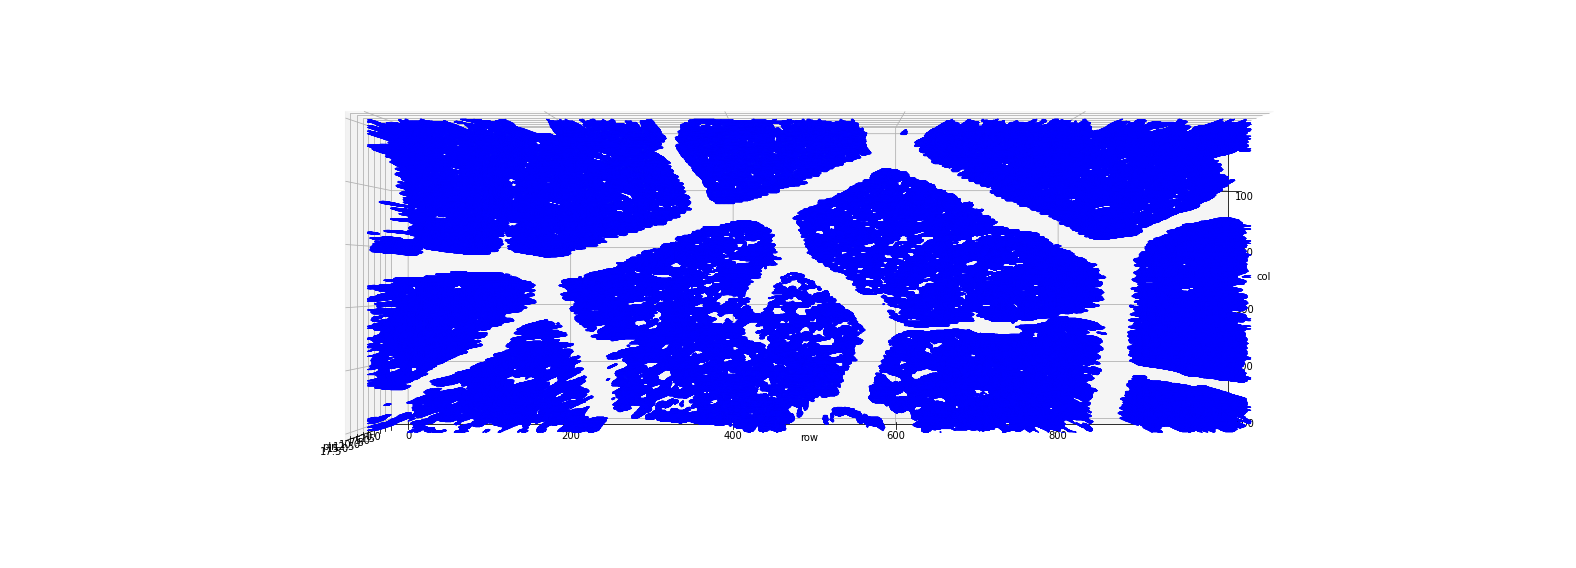

finished


In [4]:
#3d image generator. It will run out of ram really fast, can only handle small image stacks (20x500x988 @ 25 gigs of ram)
#select region you want to visualize
selected_cell = 2
print('region') 
print(selected_cell)

# skimage.measure.marching_cubes expects ordering (row, col, pln)
volume = (relabeled == regionprops[selected_cell].label).transpose(1, 2, 0)

verts_px, faces_px, _, _ = measure.marching_cubes_lewiner(volume, level=0)
surface_area_pixels = measure.mesh_surface_area(verts_px, faces_px)

verts, faces, _, _ = measure.marching_cubes_lewiner(volume, level=0)
surface_area_actual = measure.mesh_surface_area(verts, faces)

print("surface area (total pixels): {:0.2f}".format(surface_area_pixels))
print("surface area (actual): {:0.2f}".format(surface_area_actual))

fig = plt.figure(figsize=(22, 8))
ax = fig.add_subplot(111, projection="3d")

mesh = Poly3DCollection(verts_px[faces_px])
mesh.set_edgecolor("b")
ax.add_collection3d(mesh)

ax.set_xlabel("col")
ax.set_ylabel("row")
ax.set_zlabel("pln")

min_pln, min_row, min_col, max_pln, max_row, max_col = regionprops[selected_cell].bbox

ax.set_xlim(min_row, max_row)
ax.set_ylim(min_col, max_col)
ax.set_zlim(min_pln, max_pln)

for angle in range(0, 360):
    ax.view_init(elev=90,azim=0)
    
plt.tight_layout()
plt.show()

print('finished')